In [2]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras import layers
from tensorflow.keras import Sequential
import numpy as np
from tensorflow.keras.layers import Dense, Input, MaxPooling2D, Dropout, Flatten
from tensorflow.keras import metrics
from tensorflow.keras.preprocessing.image import ImageDataGenerator
%matplotlib inline
import matplotlib.pyplot as plt

In [3]:
img_height = 400
img_width = 400
batch_size = 32
epochs = 3

In [4]:
datagen = ImageDataGenerator(rescale=1./255)

train_generator = datagen.flow_from_directory('data/train',
                                                    target_size=(img_height, img_width),
                                                    batch_size=batch_size,
                                                    class_mode='categorical')

valid_generator = datagen.flow_from_directory('data/test',
                                                    target_size=(img_height, img_width),
                                                    batch_size=batch_size,
                                                    class_mode='categorical')


Found 7631 images belonging to 2 classes.
Found 1907 images belonging to 2 classes.


In [5]:
# for image_batch, labels_batch in train_generator:
#     print(image_batch.shape)
#     print(labels_batch.shape)
#     break

In [6]:
pretrained_model = tf.keras.applications.VGG16(
    include_top=False,
    weights="imagenet",
    input_tensor=None,
    input_shape=(img_height, img_width, 3),
    pooling=None,
    classes=1000
)

pretrained_model.trainable=False

model=Sequential()

model = tf.keras.Sequential()

for layer in pretrained_model.layers[:-1]:
    model.add(layer)
    
for layer in model.layers:
    layer.trainable = False

model.add(tf.keras.layers.Conv2D(filters=1024, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(tf.keras.layers.GlobalAveragePooling2D())
model.add(tf.keras.layers.Dense(2, activation='softmax'))


model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=[metrics.AUC(), 'accuracy'])


In [7]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 400, 400, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 400, 400, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 200, 200, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 200, 200, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 200, 200, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 100, 100, 128)     0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 100, 100, 256)    

In [8]:
history = model.fit(
  train_generator,
  steps_per_epoch=train_generator.samples//batch_size,
  validation_data=valid_generator,
  validation_steps=valid_generator.samples//batch_size,
  epochs=epochs
)

Epoch 1/3
238/238 [==============================] - 201s 846ms/step - loss: 0.4664 - auc: 0.8674 - accuracy: 0.7868 - val_loss: 0.3260 - val_auc: 0.9355 - val_accuracy: 0.8602
Epoch 2/3
238/238 [==============================] - 203s 852ms/step - loss: 0.3172 - auc: 0.9389 - accuracy: 0.8634 - val_loss: 0.2758 - val_auc: 0.9551 - val_accuracy: 0.8941
Epoch 3/3
238/238 [==============================] - 203s 853ms/step - loss: 0.2618 - auc: 0.9587 - accuracy: 0.9000 - val_loss: 0.2120 - val_auc: 0.9749 - val_accuracy: 0.9317


In [9]:
get_output = tf.keras.backend.function([model.layers[0].input],
                                       [model.layers[-3].output, model.layers[-1].output])
[conv_outputs, predictions] = get_output(valid_generator[0][0])
class_weights = model.layers[-1].get_weights()[0]

In [10]:
output = []
for num, idx in enumerate(np.argmax(predictions,axis=1)):
    cam = tf.matmul(np.expand_dims(class_weights[:,idx],axis = 0),
                    np.transpose(np.reshape(conv_outputs[num],(25*25,1024))))
    cam = tf.keras.backend.eval(cam)
    output.append(cam)

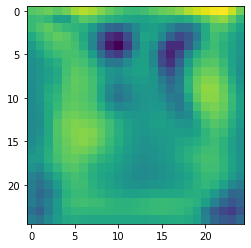

In [27]:
plt.imshow(np.reshape(output[0][0], (25, 25)))

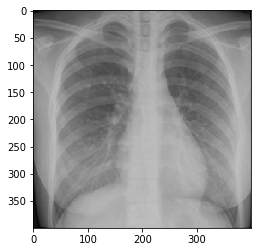

In [28]:
plt.imshow(valid_generator[0][0][0])

In [33]:
model.predict(valid_generator[0][0])

array([[7.4134207e-01, 2.5865793e-01],
       [2.4380408e-02, 9.7561967e-01],
       [5.3750027e-02, 9.4624996e-01],
       [6.8734944e-01, 3.1265053e-01],
       [8.1491297e-01, 1.8508708e-01],
       [3.1399059e-01, 6.8600941e-01],
       [7.1868487e-04, 9.9928135e-01],
       [9.5511597e-01, 4.4884030e-02],
       [2.4743460e-01, 7.5256538e-01],
       [1.2028016e-01, 8.7971985e-01],
       [2.3514682e-02, 9.7648525e-01],
       [2.9159902e-02, 9.7084010e-01],
       [2.5066593e-01, 7.4933410e-01],
       [9.0643752e-01, 9.3562484e-02],
       [9.1835862e-01, 8.1641443e-02],
       [6.6485423e-01, 3.3514583e-01],
       [2.4793040e-02, 9.7520691e-01],
       [8.9232451e-01, 1.0767554e-01],
       [2.4295190e-02, 9.7570473e-01],
       [8.2680118e-01, 1.7319883e-01],
       [9.1498929e-01, 8.5010670e-02],
       [9.1910964e-01, 8.0890357e-02],
       [9.2854148e-01, 7.1458548e-02],
       [8.5169101e-01, 1.4830899e-01],
       [7.6939511e-01, 2.3060490e-01],
       [1.3418662e-02, 9.